In [1]:
#| default_exp mesh

## Mesh data structure

> Data structure for triangular meshes and UV maps

In this notebook, we define a class for triangular meshes with UV maps, and show how to use it with the data from the ``basics_example`` folder.

Let's **define the metadata for the example dataset**: the filename, resolution in microns, and how much we subsampled for segmentation purposes. This is important for correctly scaling mesh vertex positions when computing the mesh from image data.

**Important convention** For sanity's sake, we will always store all mesh coordinates in microns. This means rescaling appropriately after calculating the mesh from the 3d segmentation.

In [2]:
metadata_dict = {'filename': 'datasets/basics_example/basics_example',
                 'resolution_in_microns': (1, 0.36, 0.36), # you can typically get this from the .tif metadata
                 'subsampling_factors': (1, 1/3, 1/3), # how much you subsampled your image for segmentation
                }

In [3]:
#| export

import numpy as np
from typing import Iterable
import os
from copy import deepcopy
import warnings

import igl

In [4]:
#| hide
import matplotlib.pyplot as plt
import nbdev

In [5]:
#| export

def flatten(lst, max_depth=1000, iter_count=0):
    """
    Flatten a list of lists into a list.

    Also works with inhomogeneous lists, e.g., [[0,1],2]. The argument
    depth determines how "deep" to flatten the list, e.g. with max_depth=1:
    [[(1,0), (1,0)]] -> [(1,0), (1,0)].

    Parameters
    ----------
    lst : list
        list-of-lists.
    max_depth : int, optional
        To what depth to flatten the list.
    iter_count : int, optional
        Helper argument for recursion depth determination.
    
    Returns
    -------
    iterator
        flattened list.
    """
    for el in lst:
        if (isinstance(el, Iterable) and not isinstance(el, (str, bytes))
                and iter_count < max_depth):
            yield from flatten(el, max_depth=max_depth,
                               iter_count=iter_count+1)
        else:
            yield el
            
def pad_list(lst, length=3, fill_value=np.nan):
    """Pad end of list with fill_value if shorter than the desired length."""
    return lst + max([0, (length-len(lst))]) * [fill_value,]

def unique(sequence):
    """Create list of unique entries in sequence while preserving order"""
    seen = set()
    return [x for x in sequence if not (x in seen or seen.add(x))]

def index_else_nan(arr, inds):
    """Return arr[inds], masked so that the result is np.nan wherever ind is nan"""
    if len(np.shape(inds)):
        inds = np.array(inds)
    mask = np.isnan(inds)
    masked_inds = np.copy(inds)
    masked_inds[mask] = 0
    masked_inds = masked_inds.astype(int)    
    selected = arr[masked_inds]
    selected[mask] = np.nan
    return selected

def invert_dictionary(my_map, assume_unique=False):
    """
    Invert key -> value map defined by a dictionary
    
    If assume_unique is True, key/value pairs are assumed to be unique.
    Else, a dictionary of lists is returned. Each entry is a list
    of keys that map to the given value.
    """
    if assume_unique:
        return {v: k for k, v in my_map.items()}
    inv_map = {}
    for k, v in my_map.items():
        inv_map[v] = inv_map.get(v, []) + [k]
    return inv_map

def _match_normals_to_vertices(vs, ns, fs):
    """Internal helper function for reading in meshes. fs = [(vertex, texture, normal)]"""
    vn_dict = {v: [] for v in range(vs.shape[0])}
    for v, _, n in flatten(fs, max_depth=1):
        if not np.isnan(n):
            vn_dict[v].append(n)
    return np.stack([ns[vn_dict[i]].mean(axis=0) for i in range(vs.shape[0])], axis=0)

### The `ObjMesh` class

We now define our main class for mesh io and mesh handling. We save all meshes as wavefront `.obj` files (see [wikipedia](https://en.wikipedia.org/wiki/Wavefront_.obj_file)). In Python, we represent missing entries (such as a vertex that doesn't have a normal by `np.nan`.

For reading, writing, holding, and handling `.obj` meshes, we will create the `ObjMesh` class. You can think of an `.obj` mesh as a _map_ between two meshes (the mesh in 3d, and its texture coordinates in 2d), defined on a per-face basis.

**Handling of non-triangular meshes**

We prefer to work with triangulated meshes. For triangulated meshes:
1. there is a well-defined way to _interpolate_ data across mesh faces (barycentric interpolation)
2. the deformation of a face under a mapping (e.g. cartographic map to the plane) is uniquely defined
3. many more algorithms are available (notably in `igl`)

Non-triangular meshes and meshes with mixes of triangles and higher-order faces, like quads, are supported by this data structure, but not recommended.

In [8]:
#| export

class ObjMesh:
    """
    Simple class for reading, holding, transforming, and saving 3d polygonal meshes in the .obj format.
    See https://en.wikipedia.org/wiki/Wavefront_.obj_file.

    An ObjMesh comprises vertices and faces, describing a surface in 3d, 
    (optionally) per-vertex normals, and (optionally), texture vertices and
    texture faces that describe how the surface is mapped to 2d.
    
    Vertices, texture_vertices, normals are np.arrays, faces is a list.
    Each face is either a list of vertex indices, or, if the mesh
    has texture information, a list of vertex/texture vertex index pairs, describing
    which face maps to which texture face. Note: the number of texture vertices and
    vertices is not necessarily equal!
    
    Normals are always defined per-vertex, i.e. self.normals[i] is the normal vector at
    self.vertices[i].   Missing data is represented by np.nan.
    Faces can be any length (triangles, quads, ...). Indices start at 0!
    
    **Attributes**
    
    vertices : np.array of shape (#vertices, dimension).
    
    texture_vertices : np.array of shape (#texture vertices, 2) or None

    normals : np.array of shape (#vertices, dimension) or None
    
    faces : List[List[int]] or List[List[(int, int]]]

    **Property methods (use like attributes)**

    only_vertices : bool, whether mesh has texture information
    
    is_triangular : bool
                
    tris : np.array of shape (#triangular faces, 3). Triangular 3d faces
        
    texture_tris : np.array of shape (#triangular faces, 3). Triangular texture faces.
    Note: undefined texture faces are represented by [0, 0, 0]
    
    """
    
    def __init__(self, vertices, faces, texture_vertices=None, normals=None, name=None):
        self.vertices, self.faces = (vertices, faces)
        self.texture_vertices, self.normals = (texture_vertices, normals)
        self.name = None
       
    @staticmethod
    def read_obj_fallback(filename):
        """
        Return vertices, texture vertices, normals, and faces from an obj file.
        
        Fallback option for meshes containing mixed faces (e.g. triangles and quads),
        or partial UV/normal information, which is not handled by libigl.

        Faces are lists of pairs of vertex/texture vertex indices. If a certain vertex has no texture 
        associated with it, the entry is np.nan, else it is an index into the vertex/texture arrays
        (note: indices of returned faces start at 0!). See https://en.wikipedia.org/wiki/Wavefront_.obj_file.
        
        Intended for .obj files containing a single object only. Will emit a warning if multiple objects
        are detected.

        Parameters
        ----------
        filename : str
            filename
        Returns
        -------
        mesh: ObjMesh
        """
        def _str_to_int_or_nan(x):
            """Convert string to int or np.nan if string is empty"""
            if x == '':
                return np.nan
            return int(x)
        with open(filename, 'r') as f:
            lines = f.readlines()
        names = [ln.split()[1:] for ln in lines if ln.startswith("o ")]
        if len(names) > 1:
            warnings.warn(f"Warning: multiple meshes in .obj file", RuntimeWarning)
        name = None if len(names) == 0 else names[0]
        vs = np.array([ln.split()[1:] for ln in lines if ln.startswith("v ")]).astype(float)
        vts = np.array([ln.split()[1:] for ln in lines if ln.startswith("vt ")]).astype(float)
        ns = np.array([ln.split()[1:] for ln in lines if ln.startswith("vn ")]).astype(float)
        fs = [ln.split()[1:] for ln in lines if ln.startswith("f ")]
        fs = [[pad_list([_str_to_int_or_nan(y)-1 for y in x.split("/")], length=3, fill_value=np.nan)
               for x in f] for f in fs]
        if ns.shape == (0,):
            ns = None
        else: # match up normals to vertices
            ns = _match_normals_to_vertices(vs, ns, fs)
            ns = (ns.T / np.linalg.norm(ns, axis=-1)).T
        if vts.shape == (0,): # if there is no texture information
            fs = [[v[0] for v in f] for f in fs]
            mesh = ObjMesh(vs, fs, texture_vertices=None, normals=ns, name=name)
        else: 
            fs = [[v[:2] for v in f] for f in fs]
            mesh = ObjMesh(vs, fs, texture_vertices=vts, normals=ns, name=name)
        if not mesh.is_triangular:
            warnings.warn(f"Warning: non-triangular meshes are deprecated", DeprecationWarning)
        return mesh
    
    @staticmethod  
    def read_obj(filename):
        """
        Return vertices, texture vertices, normals, and faces from an obj file.

        Faces are lists of pairs of vertex/texture vertex indices. If a certain vertex has no texture 
        associated with it, the entry is np.nan, else it is an index into the vertex/texture arrays
        (note: indices of returned faces start at 0!). See https://en.wikipedia.org/wiki/Wavefront_.obj_file.
        
        Intended for .obj files containing a single object only.

        Parameters
        ----------
        filename : str
            filename
        Returns
        -------
        mesh: ObjMesh
        """
        try:
            vertices, texture_vertices, normals, faces, texture_faces, normal_faces = igl.read_obj(filename)
            if normals.shape[0] == 0:
                obj_normals = None
            else:
                obj_normals = igl.average_onto_vertices(vertices, faces, normals[normal_faces].mean(axis=1))
                obj_normals = (obj_normals.T / np.linalg.norm(obj_normals, axis=-1)).T
            if texture_faces.shape[0] == 0:
                obj_texture_vertices = None
                obj_faces = faces
            else:
                obj_texture_vertices = texture_vertices
                obj_faces = np.stack([faces, texture_faces], axis=2).tolist()
            mesh = ObjMesh(vertices, obj_faces, obj_texture_vertices, obj_normals)
            if not mesh.is_triangular:
                warnings.warn(f"Warning: non-triangular meshes are deprecated", DeprecationWarning)
            return mesh 
        except ValueError:
            return ObjMesh.read_obj_fallback(filename)
        
    def write_obj(self, filename, include_uv_and_normals=True):
        """
        Write mesh to .obj format.

        Can write texture coordinates and normals if included. 

        Parameters
        ----------
        filename : str
            filename to save to
        include_uv_and_normals : bool, default True
            include UV and normal information if available.
            
        Returns
        -------
        None

        """
        def _int_or_nan_to_str(x):
            """Convert int/nan to string. np.nan is converted to the empty string"""
            if np.isnan(x):
                return ''
            return str(x)
        namelines = ["o {}\n".format(self.name)] if self.name is not None else []
        if self.only_vertices:
            vlines = ["v {} {} {}\n".format(*v) for v in self.vertices]
            flines = ["f {} {} {}\n".format(*[int(v+1) for v in fc]) for fc in self.faces]
            with open(filename, 'w') as f:
                f.writelines(namelines)
                f.writelines(vlines)
                f.writelines(flines)
        if not self.only_vertices and not include_uv_and_normals:
            vlines = ["v {} {} {}\n".format(*v) for v in self.vertices]
            flines = ["f {} {} {}\n".format(*[int(v[0]+1) for v in fc]) for fc in self.faces]
            with open(filename, 'w') as f:
                f.writelines(namelines)
                f.writelines(vlines)
                f.writelines(flines)
        if not self.only_vertices and include_uv_and_normals:
            assert all([len(v)==2 for v in flatten(self.faces, max_depth=1)]), "each vertex must have 2 indices"
            texture_vertices = [] if self.texture_vertices is None else self.texture_vertices
            vlines = ["v {} {} {}\n".format(*v) for v in self.vertices]
            vtlines = ["vt {} {}\n".format(*vt) for vt in texture_vertices]
            nlines = ["vn {} {} {}\n".format(*n) for n in self.normals] if self.normals is not None else []
            faces_with_normals = [[[v[0], v[1], v[0]] for v in fc] for fc in self.faces]
            flines = ["f {} {} {}\n".format(*["{}/{}/{}".format(*[_int_or_nan_to_str(ix+1) for ix in v])
                                              for v in fc]) for fc in faces_with_normals]
            with open(filename, 'w') as f:
                f.writelines(namelines)
                f.writelines(vlines)
                f.writelines(vtlines)
                f.writelines(nlines)
                f.writelines(flines)
        return None
    
    @property
    def only_vertices(self):
        """Check if mesh has any texture information"""
        if self.texture_vertices is None:
            assert all([not isinstance(v, Iterable) for v in flatten(self.faces, max_depth=1)]), \
                "If texture_vertices is None, faces must be lists of vertex indices only"
            return True
        return False
    
    @property
    def is_triangular(self):
        """Check if mesh has triangular faces only."""
        return all([len(fc)==3 for fc in self.faces]) 
            
    @property
    def tris(self):
        """Get all 3d triangles in mesh as a numpy array. Entries are vertex indices."""
        if self.only_vertices:
            return np.array([fc for fc in self.faces if len(fc)==3])
        return np.array([[v[0] for v in fc] for fc in self.faces if len(fc)==3])
    
    @property
    def texture_tris(self):
        """Get all texture triangles in mesh as a numpy array. Entries are texture_vertex indices."""
        if self.only_vertices:
            return np.array([[0,0,0] for fc in self.faces if len(fc)==3])
        return np.nan_to_num(np.array([[v[1] for v in fc] for fc in self.faces if len(fc)==3])).astype(int)
    
    @property
    def vertex_textures(self):
        """Get array of vertex texture coordinates. If multiple textures per vertex are stored,
        the last one is returned."""
        if self.only_vertices:
            return np.nan*np.ones_like(self.vertices)[:,:2]
        if len(self.texture_vertices) == 0:
            return np.nan*np.ones_like(self.vertices)[:,:2]
        v_vt_pairs = [np.nan for v in range(self.vertices.shape[0])] # in case there are stray vertices w/out face
        for v, vt in flatten(self.faces, max_depth=1):
            v_vt_pairs[v] = vt
        return index_else_nan(self.texture_vertices, np.array(v_vt_pairs))
    
    def set_normals(self):
        """Recompute normals based on 3d positions. Only works for triangular meshes."""
        if not self.is_triangular:
            warnings.warn(f"Warning: mesh not triangular - normals may be incorrect", RuntimeWarning)
        normals = igl.per_vertex_normals(self.vertices, self.tris,)
        self.normals = (normals.T / np.linalg.norm(normals, axis=1)).T
        return None
        
    def get_uv_index_to_vertex_index_map(self):
        """Get map from texture vertex index to the corresponding 3d vertex index as a dictionary."""
        return {v[1]: v[0] for v in flatten(self.faces, max_depth=1) if not np.isnan(v[1])}
    
    def get_vertex_index_to_uv_index_map(self):
        """
        Get map from 3d vertex index to the corresponding UV vertex index as a dictionary.
        
        Note: each dict value is a list, since a 3d vertex can map to multiple UV vertices.
        For vertices that do not have any corresponding UV vertex, the list is empty.
        """
        uv_to_vertex = self.get_uv_index_to_vertex_index_map()
        vertex_to_uv = invert_dictionary(uv_to_vertex, assume_unique=False)
        missing = set(range(self.vertices.shape[0])).difference(set(vertex_to_uv.keys()))
        for m in missing:
            vertex_to_uv[m] = []
        return vertex_to_uv
        
    def get_vertex_to_texture_vertex_indices(self):
        """
        Get an array of indices into 3d vertices that map them to the corresponding texture vertices.
        
        Useful for translating per-vertex data into per-texture-vertex data:
        array -> array[self.get_vertex_to_texture_vertex_indices()]
        """
        texture_vertex_dict = self.get_uv_index_to_vertex_index_map()
        return np.array([texture_vertex_dict[i] for i in range(self.texture_vertices.shape[0])])
        
    def map_per_vertex_to_per_texture_vertex(self, field):
        """
        Map per-vertex field (array of shape (n_vertices, ...)) to texture vertices.
        vertices.
        """
        return field[self.get_vertex_to_texture_vertex_indices()]
        
    def map_per_texture_vertex_to_per_vertex(self, field):
        """
        Map per-texture vertex field (array of shape (n_texture_vertices, ...)) to 3d vertices.
        vertices.
        """
        vertex_to_uv = self.get_vertex_index_to_uv_index_map()
        return np.stack([field[vertex_to_uv[i]].mean(axis=0) for i in range(self.vertices.shape[0])], axis=0)
        
    def cut_along_seams(self):
        """
        Cut mesh along texture seams.

        Returns a new ObjMesh in which the topology of the vertices matches the topology of the texture vertices,
        by duplicating vertices along "seams" (i.e. which have multiple corresponding texture vertices),
        and discarding any vertices without texture coordinates.
        
        Returns
        -------
        ObjMesh

        """
        assert not self.only_vertices and len(self.normals) > 0 and len(self.texture_vertices) > 0, \
            """Method requires texture or normal information"""
        texture_vertex_dict = {v[1]: v[0] for v in flatten(self.faces, max_depth=1) if not np.isnan(v[1])}
        matched_vertex_inds = np.array([texture_vertex_dict[i] for i in range(self.texture_vertices.shape[0])])
        matched_vertices = self.vertices[matched_vertex_inds]
        matched_normals = index_else_nan(self.normals, matched_vertex_inds)
        cut_faces = [[[v[1], v[1]] for v in fc] for fc in self.faces if not any([np.isnan(v[1]) for v in fc])]
        return ObjMesh(matched_vertices, cut_faces, texture_vertices=self.texture_vertices,
                       normals=matched_normals, name=self.name)
        
    def apply_affine_to_mesh(self, trafo,):
        """
        Apply affine transformation to mesh.
        
        Rotate/shear and translate vertices, rotate/shear and renormalize normals,
        flip faces if the transformation determinant is -1.

        Parameters
        ----------
        trafo : np.array of shape (4,4) or (3,3)
            Transformation matrix. If (4,4), it is interpreted as an affine transformation.

        Returns
        -------
        newmesh : ObjMesh
            Transformed mesh.

        """
        assert trafo.shape==(3,3) or trafo.shape==(4,4), "Transformation matrix must be 3*3 or 4*4"
        if trafo.shape == (3,3):
            trafo_matrix, trafo_translate = (trafo, np.zeros(3))
        elif trafo.shape == (4,4):
            trafo_matrix, trafo_translate = (trafo[:3,:3], trafo[:3,-1])
        newmesh = deepcopy(self)
        newmesh.vertices = self.vertices@trafo_matrix.T + trafo_translate
        if self.normals is not None:
            normals_transformed = self.normals@trafo_matrix.T
            newmesh.normals = (normals_transformed.T / np.linalg.norm(normals_transformed, axis=-1)).T
        if np.linalg.det(trafo_matrix) < 0:
            newmesh.faces = [fc[::-1] for fc in self.faces]
        return newmesh

In [9]:
nbdev.show_doc(ObjMesh.set_normals)

---

[source](https://github.com/nikolas-claussen/blender-tissue-cartography/blob/main/blender_tissue_cartography/mesh.py#L329){target="_blank" style="float:right; font-size:smaller"}

### ObjMesh.set_normals

>      ObjMesh.set_normals ()

*Recompute normals based on 3d positions. Only works for triangular meshes.*

In [10]:
nbdev.show_doc(ObjMesh.get_uv_index_to_vertex_index_map)

---

[source](https://github.com/nikolas-claussen/blender-tissue-cartography/blob/main/blender_tissue_cartography/mesh.py#L337){target="_blank" style="float:right; font-size:smaller"}

### ObjMesh.get_uv_index_to_vertex_index_map

>      ObjMesh.get_uv_index_to_vertex_index_map ()

*Get map from texture vertex index to the corresponding 3d vertex index as a dictionary.*

In [11]:
nbdev.show_doc(ObjMesh.get_vertex_index_to_uv_index_map)

---

[source](https://github.com/nikolas-claussen/blender-tissue-cartography/blob/main/blender_tissue_cartography/mesh.py#L341){target="_blank" style="float:right; font-size:smaller"}

### ObjMesh.get_vertex_index_to_uv_index_map

>      ObjMesh.get_vertex_index_to_uv_index_map ()

*Get map from 3d vertex index to the corresponding UV vertex index as a dictionary.

Note: each dict value is a list, since a 3d vertex can map to multiple UV vertices.
For vertices that do not have any corresponding UV vertex, the list is empty.*

In [12]:
nbdev.show_doc(ObjMesh.get_vertex_to_texture_vertex_indices)

---

[source](https://github.com/nikolas-claussen/blender-tissue-cartography/blob/main/blender_tissue_cartography/mesh.py#L355){target="_blank" style="float:right; font-size:smaller"}

### ObjMesh.get_vertex_to_texture_vertex_indices

>      ObjMesh.get_vertex_to_texture_vertex_indices ()

*Get an array of indices into 3d vertices that map them to the corresponding texture vertices.

Useful for translating per-vertex data into per-texture-vertex data:
array -> array[self.get_vertex_to_texture_vertex_indices()]*

In [13]:
nbdev.show_doc(ObjMesh.map_per_vertex_to_per_texture_vertex)

---

[source](https://github.com/nikolas-claussen/blender-tissue-cartography/blob/main/blender_tissue_cartography/mesh.py#L365){target="_blank" style="float:right; font-size:smaller"}

### ObjMesh.map_per_vertex_to_per_texture_vertex

>      ObjMesh.map_per_vertex_to_per_texture_vertex (field)

*Map per-vertex field (array of shape (n_vertices, ...)) to texture vertices.
vertices.*

In [14]:
nbdev.show_doc(ObjMesh.map_per_texture_vertex_to_per_vertex)

---

[source](https://github.com/nikolas-claussen/blender-tissue-cartography/blob/main/blender_tissue_cartography/mesh.py#L372){target="_blank" style="float:right; font-size:smaller"}

### ObjMesh.map_per_texture_vertex_to_per_vertex

>      ObjMesh.map_per_texture_vertex_to_per_vertex (field)

*Map per-texture vertex field (array of shape (n_texture_vertices, ...)) to 3d vertices.
vertices.*

In [15]:
nbdev.show_doc(ObjMesh.cut_along_seams)

---

[source](https://github.com/nikolas-claussen/blender-tissue-cartography/blob/main/blender_tissue_cartography/mesh.py#L380){target="_blank" style="float:right; font-size:smaller"}

### ObjMesh.cut_along_seams

>      ObjMesh.cut_along_seams ()

*Cut mesh along texture seams.

Returns a new ObjMesh in which the topology of the vertices matches the topology of the texture vertices,
by duplicating vertices along "seams" (i.e. which have multiple corresponding texture vertices),
and discarding any vertices without texture coordinates.*

In [16]:
nbdev.show_doc(ObjMesh.apply_affine_to_mesh)

---

[source](https://github.com/nikolas-claussen/blender-tissue-cartography/blob/main/blender_tissue_cartography/mesh.py#L403){target="_blank" style="float:right; font-size:smaller"}

### ObjMesh.apply_affine_to_mesh

>      ObjMesh.apply_affine_to_mesh (trafo)

*Apply affine transformation to mesh.

Rotate/shear and translate vertices, rotate/shear and renormalize normals,
flip faces if the transformation determinant is -1.*

|    | **Type** | **Details** |
| -- | -------- | ----------- |
| trafo | np.array of shape (4,4) or (3,3) | Transformation matrix. If (4,4), it is interpreted as an affine transformation. |
| **Returns** | **ObjMesh** | **Transformed mesh.** |

In [17]:
#| export

def read_other_formats_without_uv(filename):
    """
    Return vertices and faces from a non-.obj mesh file format. file.

    Supported formats are .obj, .off, .stl, .wrl, .ply, .mesh.
    Will NOT read in normals or texture coordinates. If you have texture
    coordinates, save your mesh as .obj. Will only return triangular faces.

    See https://libigl.github.io/libigl-python-bindings/igl_docs/#read_triangle_mesh.

    Parameters
    ----------
    filename : str
        filename
    Returns
    -------
    mesh: ObjMesh
        Only contains face and vertex info.
    """
    vs, fs = igl.read_triangle_mesh(filename)
    ns = igl.per_vertex_normals(vs, fs)
    return ObjMesh(vs, fs, texture_vertices=None, normals=ns, name=None)


### UV mapping by projecting from view

By design, `blender_tissue_cartography` does not feature functionality to create UV maps computationally - that's what you're supposed to do in Blender! With one exception: projection from an axis. This takes the 3d coordinates of a mesh, and projects it along a user-selected axis to 2d. This is useful when creating a projection of a mildly curved, disk-topology surface, and can directly be applied to time-lapse images.

In [89]:
#| export

def project_from_axis(mesh, axis1, axis2, translate=None, scale=None):
    """
    Create UV map by projecting 3D coordinates along an axis.

    The UV topology will be _identical_ to the 3D topology (no seams), and there may be self-intersections.

    The projected coordinates should be scaled to lie in [0,1]^2. The scale factor can be found automatically
    or be computed from the shape and resolution of a 3D image using
   
    Parameters
    ----------
    mesh : ObjMesh
    axis1 : np.array of shape (3,)
        vector defining the axis projected to U coordinate
    axis2 : np.array of shape (3,)
        vector defining the axis projected to V coordinate
    translate : np.array of shape (2,) or None
        translation to ensure UV coordinates are positive. If None, the minimum of U & V is used.
    scale : float or None
        scaling factor to ensure UV coordinates lie in [0, 1]. If None, the maximum of U & V is used.

    Returns
    -------
    mesh_projected: ObjMesh
        New mesh, with UV map. UV and 
    """
    vertices = mesh.vertices
    if mesh.only_vertices:
        faces = [[ [v, v] for v in f] for f in mesh.faces]
    else:
        faces = [[[v[0], v[0]] for v in f] for f in mesh.faces]
    axis1 = axis1/np.linalg.norm(axis1)
    axis2 = axis2/np.linalg.norm(axis2)
    texture_vertices = np.stack([vertices.dot(axis1),  vertices.dot(axis2)], axis=1)
    if translate is None:
        translate = texture_vertices.min(axis=0)
    texture_vertices -= translate
    if scale is None:
        scale = texture_vertices.max()
    texture_vertices /= scale
    mesh_projected = ObjMesh(vertices, faces, texture_vertices=texture_vertices, normals=mesh.normals, name=mesh.name)
    return mesh_projected

def compute_project_from_axis_scale(image_shape, resolution, axis1, axis2):
    """
    Compute scaling factor for UV coordinates obtained projecting 3D coordinates along an axis.

    UV coordinates must be scaled to lie between 0 and 1. To get a consistent scaling across e.g. 
    different frames of a movie, this function computes the scale factor based on the projection axes
    and the shape of the volumetric image.

    Parameters
    ----------
    image_shape : list or np.array of length 3
        Shape of image in pixels
    resolution : np.array of shape (3,)
        Resolution of image in microns/pixel along each axis
    axis2 : np.array of shape (3,)
        vector defining the axis projected to V coordinate

    Returns
    -------
    scale : float
        scaling factor to ensure UV coordinates lie in [0, 1]
    """
    # compute coordinates of bounding bo
    box_coordinates = np.array([[0,0,0],
                                [0, image_shape[1], 0],
                                [0, 0, image_shape[2]],
                                [0, image_shape[1], image_shape[2]],
                                [image_shape[0], 0, 0],
                                [image_shape[0], image_shape[1], 0],
                                [image_shape[0], 0, image_shape[2]],
                                [image_shape[0], image_shape[1], image_shape[2]]])
    box_coordinates = box_coordinates * np.array(resolution)
    axis1 = axis1/np.linalg.norm(axis1)
    axis2 = axis2/np.linalg.norm(axis2)
    scale = np.stack([box_coordinates.dot(axis1),  box_coordinates.dot(axis2)], axis=1).max()
    return scale

In [90]:
mesh_test = ObjMesh.read_obj("datasets/basics_example/basics_example_mesh_remeshed.obj")

# get the scale from the datasets/basics_example/basics_example.tif volumetric dataset
scale = compute_project_from_axis_scale(image_shape=(26, 454, 511), resolution=(1, 0.36, 0.36),
                                       axis1=np.array([0,1,0]), axis2=np.array([0,0,1]))
mesh_projected = project_from_axis(mesh_test, axis1=np.array([0,1,0]), axis2=np.array([0,0,1]), scale=scale, translate=0)

(-0.04403131115459883,
 0.9246575342465754,
 -0.049608610567514685,
 1.0417808219178084)

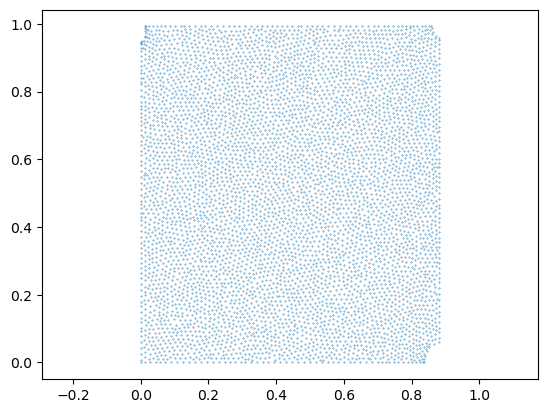

In [95]:
plt.scatter(*mesh_projected.texture_vertices.T, s=0.1)
plt.axis("equal")

### Test read/write 

In [ ]:
# let's consider some examples
mesh_cube = "datasets/basics_example/cube.obj"
mesh_mixed = "datasets/basics_example/cube_mixed.obj"

mesh_large = "datasets/registration_example/Drosophila_reference.obj"
mesh_no_uv = "datasets/basics_example/cube_no_uv.obj"
mesh_only_normals = "datasets/basics_example/cube_only_normals.obj"

mesh_partial_uv = "datasets/basics_example/cube_partial_uv.obj"
mesh_partial_uv_large = "datasets/basics_example/torus.obj"

In [ ]:
mesh = ObjMesh.read_obj(mesh_cube)


/tmp/ipykernel_1942162/3286167482.py:118: DeprecationWarning: Warning: non-triangular meshes are deprecated
  warnings.warn(f"Warning: non-triangular meshes are deprecated", DeprecationWarning)
  o Cube


In [ ]:
ObjMesh.read_obj(mesh_mixed)

  o Cube
/tmp/ipykernel_1942162/3286167482.py:82: DeprecationWarning: Warning: non-triangular meshes are deprecated
  warnings.warn(f"Warning: non-triangular meshes are deprecated", DeprecationWarning)


<__main__.ObjMesh>

In [ ]:
read_other_formats_without_uv("datasets/wrapping_example/mixed_faces_example.obj")

  o Cube


<__main__.ObjMesh>

In [ ]:
# test the read_obj function on an example
mesh_fname_data = "datasets/registration_example/Drosophila_CAAX-mCherry_mesh_remeshed.obj"

mesh = ObjMesh.read_obj(mesh_fname_data)

  o Drosophila_reference_preregistered


In [ ]:
ObjMesh.read_obj(mesh_mixed).faces

  o Cube
/tmp/ipykernel_1942162/3286167482.py:82: DeprecationWarning: Warning: non-triangular meshes are deprecated
  warnings.warn(f"Warning: non-triangular meshes are deprecated", DeprecationWarning)


[[0, 1, 3, 2],
 [2, 3, 7, 6],
 [6, 7, 5, 4],
 [4, 5, 1, 0],
 [2, 6, 4, 0],
 [3, 5, 7],
 [3, 1, 5]]

In [ ]:
#| hide

# construct an ObjMesh from the data returned by igl.read_obj

vertices, texture_vertices, normals, faces, texture_faces, normal_faces = igl.read_obj(mesh_cube)
if normals.shape[0] == 0:
    obj_normals = None
else:
    obj_normals = igl.average_onto_vertices(vertices, faces, normals[normal_faces].mean(axis=1))
if texture_faces.shape[0] == 0:
    obj_texture_vertices = None
    obj_faces = faces
else:
    obj_texture_vertices = texture_vertices
    obj_faces = np.stack([faces, texture_faces], axis=2).tolist()

ObjMesh(vertices, obj_faces, obj_texture_vertices, obj_normals)

<__main__.ObjMesh>

  o Cube


In [ ]:
#| hide
#| notest


# igl fails on mixed triangle/quad meshes. here, we'll use our own (slower) Python code as a fallback


vertices, texture_vertices, normals, faces, texture_faces, normal_faces = igl.read_obj(mesh_mixed)

  o Cube


ValueError: File 'basics_example/cube_mixed.obj' not found or containing faces of varying degree (which is not supported yet).

In [ ]:
#| hide
#| notest

# igl also fails for partial UV info

vertices, texture_vertices, normals, faces, texture_faces, normal_faces = igl.read_obj(mesh_partial_uv)

  o Cube
Error: readOBJ() face on line 32 has invalid format


ValueError: File 'basics_example/cube_partial_uv.obj' not found or containing faces of varying degree (which is not supported yet).

In [ ]:
# for meshes with partial UV information, missing data is represented by np.nan

ObjMesh.read_obj(mesh_partial_uv).faces

  o Cube
Error: readOBJ() face on line 32 has invalid format


[[[1, nan], [2, nan], [0, nan]],
 [[3, nan], [6, nan], [2, nan]],
 [[7, nan], [4, nan], [6, nan]],
 [[5, 1], [0, 2], [4, 3]],
 [[6, nan], [0, nan], [2, nan]],
 [[3, 4], [5, 1], [7, 5]],
 [[1, nan], [3, 0], [2, nan]],
 [[3, nan], [7, nan], [6, nan]],
 [[7, 12], [5, nan], [4, nan]],
 [[5, 1], [1, 6], [0, 2]],
 [[6, nan], [4, nan], [0, nan]],
 [[3, 4], [1, 6], [5, 1]]]

In [ ]:
#| hide

%%timeit
_ = ObjMesh.read_obj(mesh_large)

UsageError: Line magic function `%%timeit` not found.


In [ ]:
#| hide

%%timeit
_ = ObjMesh.read_obj_fallback(mesh_large)

UsageError: Line magic function `%%timeit` not found.


## Mesh cutting and gluing

The `cut_along_seams` method can be used to "cut" a mesh along its UV seams. This duplicates 3d vertices so that the 3d topology and the unwrapped UV topology match. For example, if your UV map cuts your sphere mesh into a north and a south hemisphere for unwrapping, `cut_along_seams` will cut the mesh into two halves.

Conversely, `glue_seams` undoes the cutting by merging close vertices.

In [ ]:
#| export

def glue_seams(mesh, decimals=None):
    """
    Merge close vertices.

    Useful to undo cutting of meshes along UV seams. Note: the exact order of vertices will
    not in general be recovered by gluing after cutting.

    Parameters
    ----------
    mesh : ObjMesh
    decimals : int or None, default 10
        Vertices whose positions agree up to 'decimals' decimals are merged. Note: you can use negative values.
        If None, estimate a value based on the shortest edge length in the mesh (-2*log_10(minimum length))

    Returns
    -------
    glued_mesh : ObjMesh
        Mesh with merged vertices.

    """
    if decimals is None:
        ls = igl.edge_lengths(mesh.vertices, mesh.tris)
        decimals = np.round(-2*np.log10(ls.min())).astype(int)
    rounded_verts = np.round(mesh.vertices, decimals=decimals)
    unique_verts, index, inverse_index = np.unique(rounded_verts, axis=0, return_index=True, return_inverse=True)
    sort_index = index.argsort()
    sort_sort_index = sort_index.argsort()
    unique_verts = unique_verts[sort_index]
    glued_faces = [[[sort_sort_index[inverse_index[v[0]]], v[1]] for v in fc] for fc in mesh.faces]
    glued_mesh = ObjMesh(unique_verts, glued_faces, texture_vertices=mesh.texture_vertices,
                         normals=None, name=mesh.name)
    glued_mesh.set_normals()
    return glued_mesh

In [ ]:
mesh = ObjMesh.read_obj("datasets/movie_example/initial_uv.obj")
mesh_cut = mesh.cut_along_seams()
glued_mesh = glue_seams(mesh_cut)
glued_mesh.write_obj("datasets/movie_example/initial_uv_glued.obj")

mesh.vertices.shape, mesh_cut.vertices.shape, glued_mesh.vertices.shape

  o mesh_01_cylinder_seams_uv


((20212, 3), (20623, 3), (12036, 3))